In [43]:
import numpy as np
import pandas as pd
import yfinance as yf
import iisignature
from scipy.optimize import minimize
from numba import jit
import matplotlib.pyplot as plt
import random
from scipy.stats import ks_2samp, wasserstein_distance,chi2,skew, kurtosis,energy_distance
from scipy.spatial.distance import cdist, pdist
import seaborn as sns
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [6]:
# period
start_date = "1997-01-01"
end_date = "2025-01-01"

# universe
tickers = {
    "S&P 500": "^GSPC"
}

prices = yf.download(
    list(tickers.values()), start=start_date, end=end_date, 
    auto_adjust=False, progress=False)["Close"]
returns = prices.pct_change().dropna()

In [14]:
# build train paths
true_paths = [returns.loc[returns.index.year==i,"^GSPC"].values[:248] for i in range(1997,2025)]
true_paths_multi = [p/p[0] for p in true_paths] # normalized

ts_multi = np.linspace(0, 247, 248)
dt_true = (ts_multi[-1] - ts_multi[0]) / (len(ts_multi) - 1)

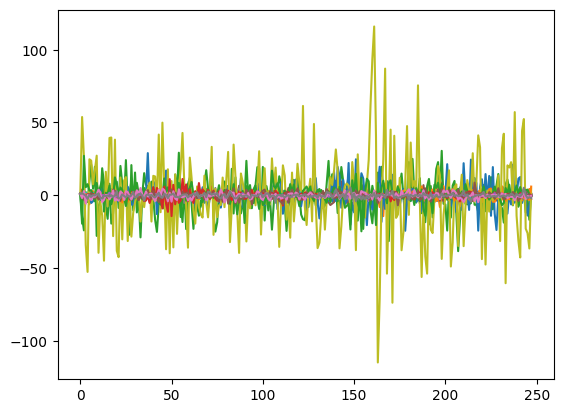

In [15]:
for i in true_paths_multi:
    plt.plot(ts_multi,i)

In [16]:
# paths: array of arrays of prices, ts: time index 1,2,3,4...
def get_path_signatures(ts, paths, window_size, sig_level, logsig):
    """
    Calculates signatures for all sliding windows of a collection of paths.
    """
    all_signatures = []
    for path in paths:
        current_ts = ts[:len(path)]
        path_2d = np.stack([current_ts, path], axis=1)
        for i in range(len(path) - window_size + 1):
            window = path_2d[i : i + window_size]
            if logsig == False:
                sig = iisignature.sig(window, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window, s)
            all_signatures.append(sig)
    return np.array(all_signatures)

def mmd_signature_linear(ts, paths1, paths2, window_size, sig_level):
    """
    Calculates the MMD between two collections of paths using the linear signature kernel.
    This is the squared Euclidean distance between the mean signatures.
    """
    sigs1 = get_path_signatures(ts, paths1, window_size, sig_level, False)
    sigs2 = get_path_signatures(ts, paths2, window_size, sig_level, False)

    if sigs1.shape[0] == 0 or sigs2.shape[0] == 0:
        return 0.0

    mean_sig1 = np.mean(sigs1, axis=0)
    mean_sig2 = np.mean(sigs2, axis=0)

    mmd_sq = np.sum((mean_sig1 - mean_sig2)**2)
    return mmd_sq

In [17]:
# model 1
def build_bootstrap_library_pathwise(ts, paths, lookback, sig_level, forward_window, logsig):
    """Builds the library of (signature, future_path_segment) pairs."""
    signatures_list, future_segments_list = [], []
    for path in paths:
        path_2d = np.stack([ts[:len(path)], path], axis=1)
        for i in range(lookback, len(path) - forward_window):
            window_2d = path_2d[i - lookback : i + 1]
            if logsig == False:
                sig = iisignature.sig(window_2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window_2d, s)
            start_val = path[i]
            future_segment = path[i+1 : i + 1 + forward_window] - start_val   
            signatures_list.append(sig)
            future_segments_list.append(future_segment)
    return np.array(signatures_list), np.array(future_segments_list)

# K-NN part. seed_path: pregiven path start longer than lookback, n_tot_step: len of the wholde path want
def generate_path_bootstrap_pathwise(seed_path, n_total_steps, lookback, sig_level, dt, library_sigs, library_segments, logsig, k, SEED):
    """Generates a full path by appending historical path segments."""
    gen_path_list = list(seed_path)
    forward_window = library_segments.shape[1]

    while len(gen_path_list) < n_total_steps:
        current_lookback_path = np.array(gen_path_list[-(lookback+1):])
        time_segment = np.arange(len(current_lookback_path)) * dt
        current_window = np.stack([time_segment, current_lookback_path], axis=1)
        if logsig == False:
                query_sig = iisignature.sig(current_window, sig_level)
        else:
            s = iisignature.prepare(2, sig_level, 'S')
            query_sig = iisignature.logsig(current_window, s)
        distances = np.linalg.norm(library_sigs - query_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]
        if SEED:
            rng = np.random.default_rng(SEED)
            chosen_neighbor_idx = rng.choice(neighbor_indices)
        else:
            chosen_neighbor_idx = np.random.choice(neighbor_indices)
        chosen_segment = library_segments[chosen_neighbor_idx]
        next_segment = gen_path_list[-1] + chosen_segment
        gen_path_list.extend(list(next_segment))

    return np.array(gen_path_list)[:n_total_steps]

In [65]:
# model 2
@jit(nopython=True)
def get_mu_model(params, y):
    """Calculates drift: mu(y) = c*y. A simple mean-reverting model."""
    c = params[0]
    return c * y

@jit(nopython=True)
def loss_function_numba(params, dS, y_levels, dt, reg_strength):
    """Numba-accelerated loss function for the simple mean-reverting drift model."""
    params_mu = params
    mu_t = np.empty(len(y_levels))
    for i in range(len(y_levels)):
        y = y_levels[i]
        mu_t[i] = get_mu_model(params_mu, y)

    residuals = dS - mu_t * dt
    loss = np.sum(residuals**2) + reg_strength * np.sum(params**2)
    return loss

def loss_function_wrapper(params, dS, y_levels, dt, reg_strength):
    return loss_function_numba(params, dS, y_levels, dt, reg_strength)

# here the forward save the de-predicted trend residual (just one step each time)
def build_hybrid_library(ts, paths, lookback, sig_level, params_mu, dt, logsig):
    """Builds a library of (signature, residual) pairs for the hybrid model."""
    signatures_list, residuals_list = [], []
    for path in paths:
        path_2d = np.stack([ts[:len(path)], path], axis=1)
        dS_path = np.diff(path)
        for i in range(lookback, len(path) - 1):
            window_2d = path_2d[i - lookback : i + 1]
            if logsig == False:
                sig = iisignature.sig(window_2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window_2d, s)
            y_i = path[i]
            predicted_drift = get_mu_model(params_mu, y_i) * dt
            actual_increment = dS_path[i]
            residual = actual_increment - predicted_drift

            signatures_list.append(sig)
            residuals_list.append(residual)

    return np.array(signatures_list), np.array(residuals_list)

def generate_path_hybrid(seed_path, n_total_steps, lookback, sig_level, dt, params_mu, library_sigs, library_residuals, logsig, k, SEED):
    """Generates a path using the hybrid SDE-bootstrap method."""
    gen_path_list = list(seed_path)
    for i in range(n_total_steps - len(seed_path)):
        current_y = gen_path_list[-1]
        predicted_drift = get_mu_model(params_mu, current_y) * dt

        current_lookback_path = np.array(gen_path_list[-(lookback+1):])
        time_segment = np.arange(len(current_lookback_path)) * dt
        current_window = np.stack([time_segment, current_lookback_path], axis=1)
        query_sig = iisignature.sig(current_window, sig_level)
        if logsig == False:
            query_sig = iisignature.sig(current_window, sig_level)
        else:
            s = iisignature.prepare(2, sig_level, 'S')
            query_sig = iisignature.logsig(current_window, s)
        distances = np.linalg.norm(library_sigs - query_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]
        if SEED:
            rng = np.random.default_rng(SEED)
            chosen_neighbor_idx = rng.choice(neighbor_indices)
        else:
            chosen_neighbor_idx = np.random.choice(neighbor_indices)

        sampled_residual = library_residuals[chosen_neighbor_idx]
        next_val = current_y + predicted_drift + sampled_residual
        gen_path_list.append(next_val)

    return np.array(gen_path_list)

In [68]:
# model 3
def build_dataset(log_paths, lookback, sig_level, dt, logsig):
    S_list, y_mu, y_logsig = [], [], []
    for log_s in log_paths:
        n_steps = len(log_s)-1
        for i in range(lookback, n_steps):
            window = log_s[i-lookback:i+1]
            times  = np.linspace(0, lookback*dt, lookback+1)
            path2d = np.stack([times, window], axis=1)
            if logsig == False:
                sig = iisignature.sig(path2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(path2d, s)
            S_list.append(sig)
            # drift target
            dlog = log_s[i+1] - log_s[i]
            y_mu.append(dlog/dt)
            # vol target
            past_rets = np.diff(window)
            sigma_est = np.std(past_rets) / np.sqrt(dt)
            y_logsig.append(np.log(sigma_est + 1e-8))
    S  = np.vstack(S_list)
    ym = np.array(y_mu)[:, None]
    ys = np.array(y_logsig)[:, None]
    return S, ym, ys

### KRR ###
def train_kernel_ridge(S, y, lam):
    # (K + lam I) alpha = y
    K = S @ S.T
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), y)
    return alpha, S

def predict(alpha, S_train, sig_new):
    k = S_train @ sig_new
    return (k @ alpha).item()

In [18]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
k = 10
SEED = 1234


# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_multi, true_paths_multi, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,False)

all_bootstrap_paths_multi = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path = true_paths_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, False, k,SEED)
    all_bootstrap_paths_multi.append(bootstrap_residuals_gen)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_multi, true_paths_multi, all_bootstrap_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   293717.734013


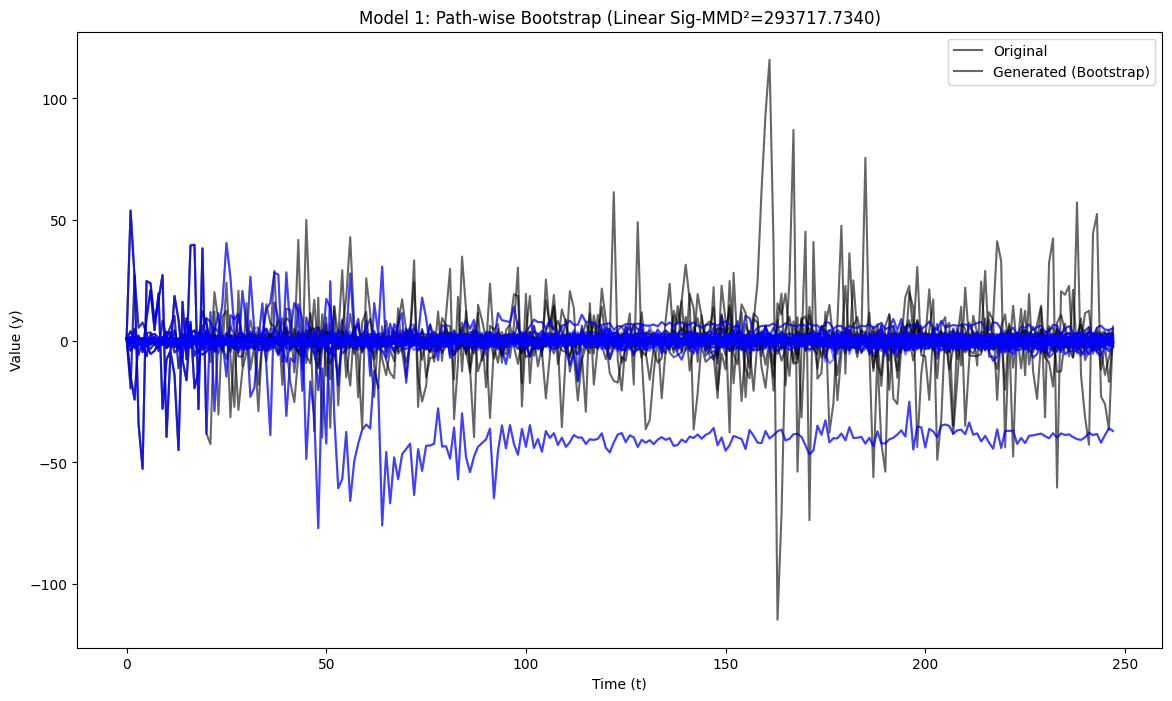

In [19]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 1: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

# Price

In [69]:
# period
start_date = "1997-01-01"
end_date = "2025-01-01"

# universe
tickers = {
    "S&P 500": "^GSPC"
}

prices = yf.download(
    list(tickers.values()), start=start_date, end=end_date, 
    auto_adjust=False, progress=False)["Close"]

true_paths = [prices.loc[prices.index.year==i,"^GSPC"].values[:248] for i in range(1997,2025)]
true_paths_multi = [p/p[0] for p in true_paths] # normalized

ts_multi = np.linspace(0, 247, 248)
dt_true = (ts_multi[-1] - ts_multi[0]) / (len(ts_multi) - 1)
# detrend paths
true_paths_residuals_multi = []
trend_lines_multi = []
for path in true_paths_multi:
    trend_coeffs = np.polyfit(ts_multi, path, 1)
    trend = np.polyval(trend_coeffs, ts_multi)
    true_paths_residuals_multi.append(path - trend)
    trend_lines_multi.append(trend)
    
train_logs_multi = np.log(true_paths_multi)

In [23]:
# model 1
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
k = 10
SEED = 1234


# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,False)

all_bootstrap_paths_multi = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, False, k,SEED)
    all_bootstrap_paths_multi.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_multi, true_paths_multi, all_bootstrap_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.007941


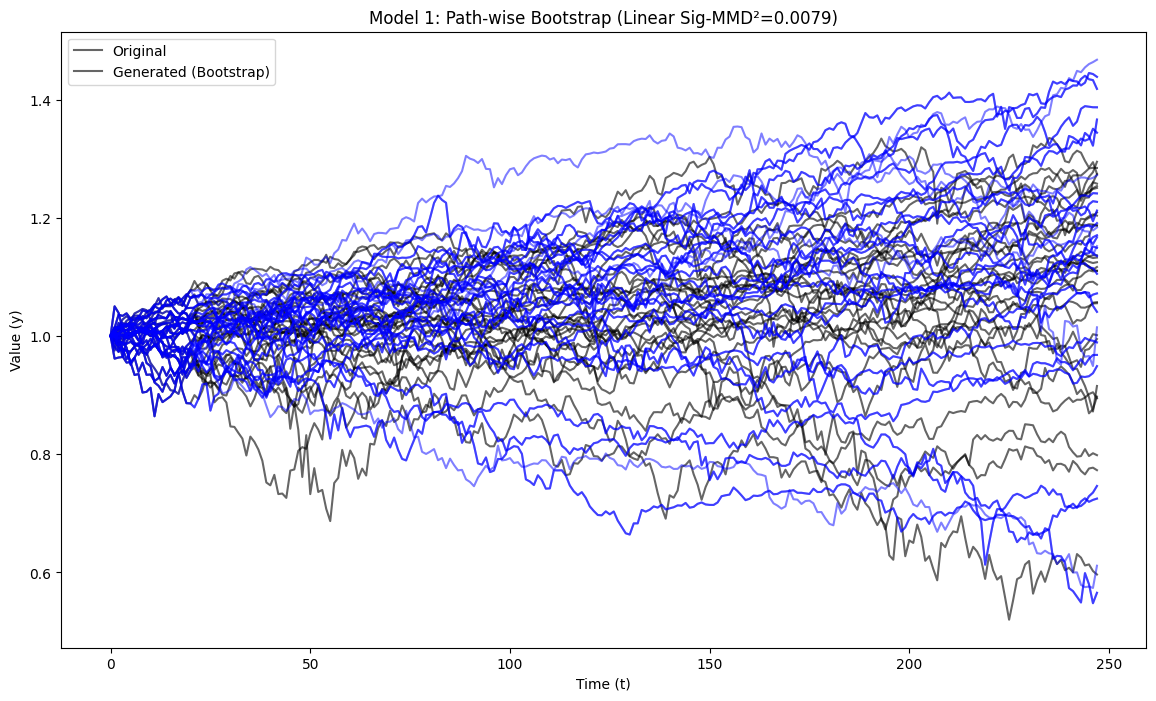

In [24]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 1: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

In [66]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
REG_STRENGTH = 1.0
k = 10
SEED = 1234
logsig = False
    
# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_multi:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_multi = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, params_mu_opt_multi, dt_true, logsig)

all_hybrid_paths_multi = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_multi, hybrid_library_sigs, hybrid_library_residuals,logsig, k, SEED)
    all_hybrid_paths_multi.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_multi, true_paths_multi, all_hybrid_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.001037


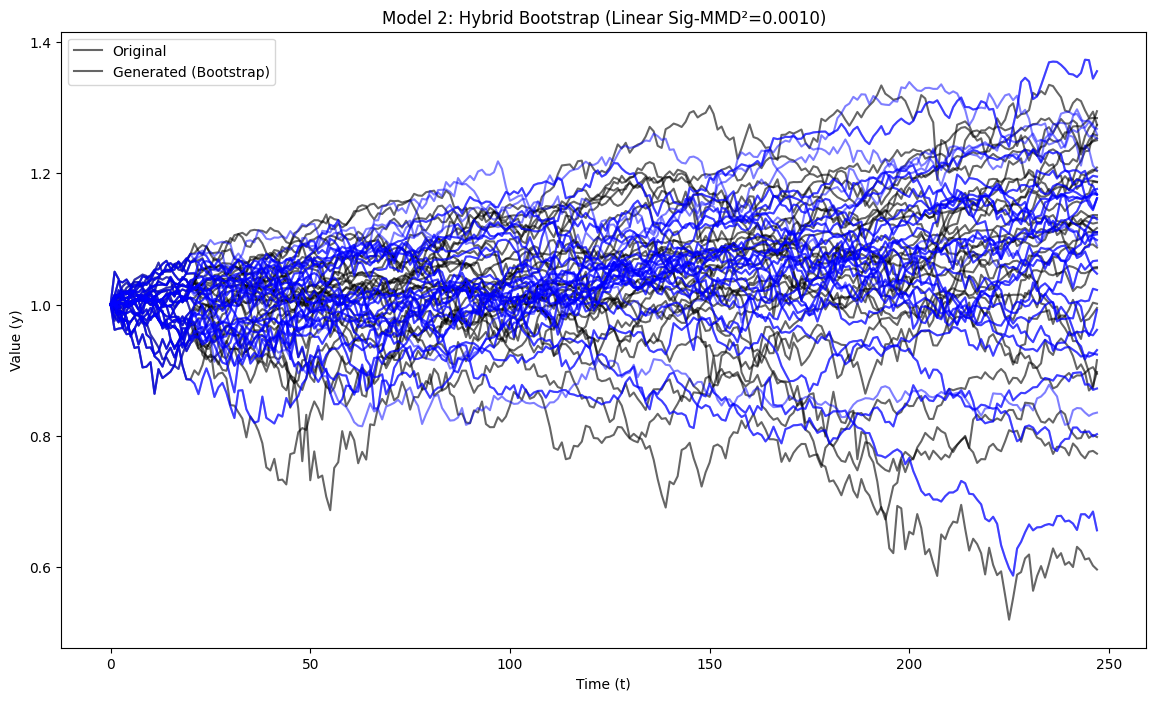

In [67]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_hybrid_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

In [71]:
T, N_STEPS = 1, len(train_logs_multi[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 15, 50
LAMBDA = 2.0
dt = T / N_STEPS
logsig = False
S_train, y_mu, y_logsig = build_dataset(train_logs_multi, LOOKBACK, SIG_LEVEL, dt,logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_multi = []
seed = train_logs_multi[0][:LOOKBACK+1]
for _ in range(N_GEN):
    rng = np.random.default_rng(SEED)
    seed_path = random.choice(train_logs_multi)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_multi.append(log_gen)

all_krr_paths_multi = np.exp(gen_logs_multi)
# Evaluate
MMD_WINDOW_SIZE = 15
SIG_LEVEL = 3
mmd_krr = mmd_signature_linear(ts_multi, true_paths_multi, all_krr_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (KRR SDE Model):      {mmd_krr:.6f}")

Dataset: 6636 samples, 30 features
Training kernel ridge for drift and log-vol...
Generating 50 new paths with random seeding...
   - Linear Sig-MMD^2 (KRR SDE Model):      0.004750


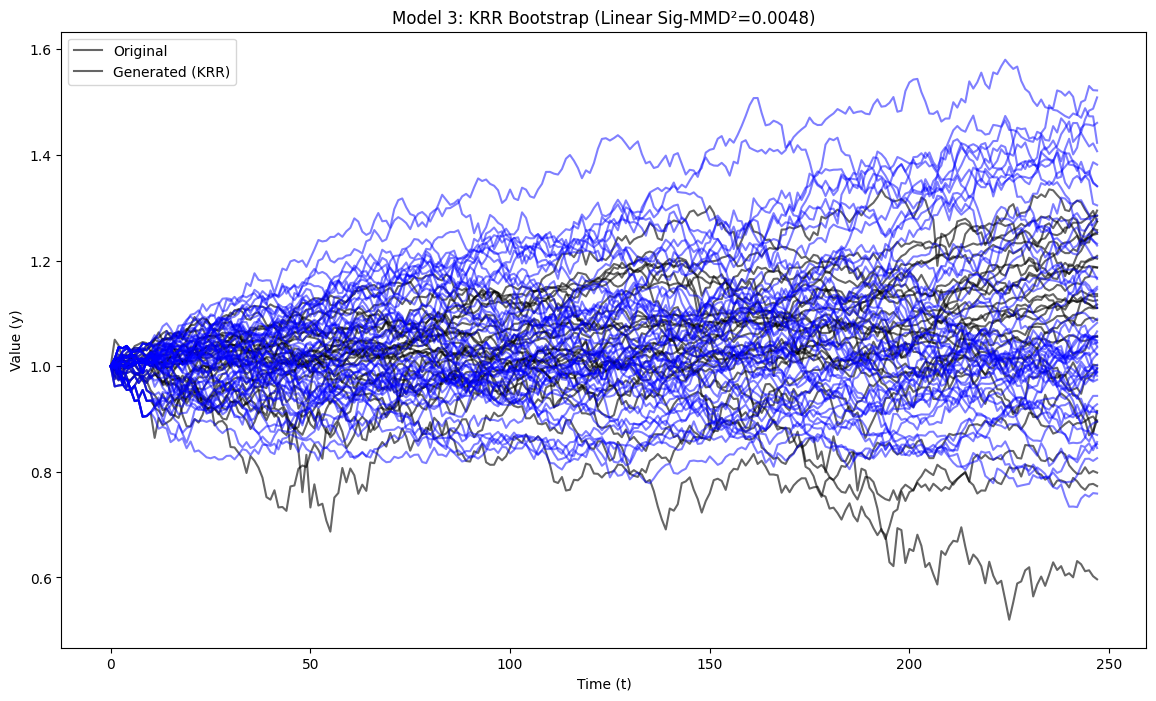

In [72]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_krr_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 3: KRR Bootstrap (Linear Sig-MMD²={mmd_krr:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (KRR)'])

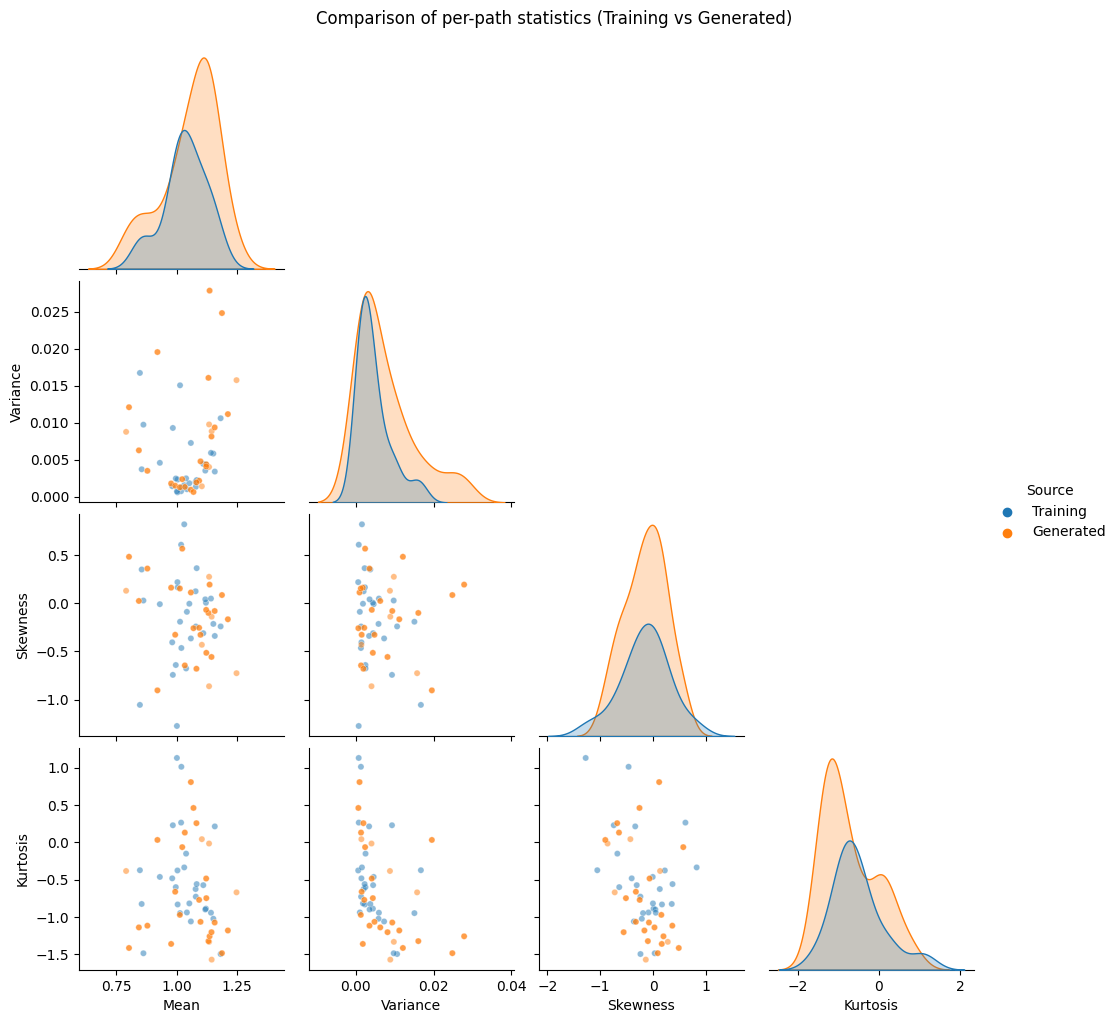

KS test on     Mean: statistic=0.263, p-value=0.136
KS test on Variance: statistic=0.226, p-value=0.269
KS test on Skewness: statistic=0.110, p-value=0.958
KS test on Kurtosis: statistic=0.409, p-value=0.003
Linear kernel MMD^2: 0.0343
RBF kernel MMD^2 = 2.0730e-02,  sigma = 0.615


In [80]:
mmd_sq_bootstrap, mmd_val_bootstrap, sigma_bootstrap,p_val_bootstrap=moment_check(true_paths_multi, all_bootstrap_paths_multi)

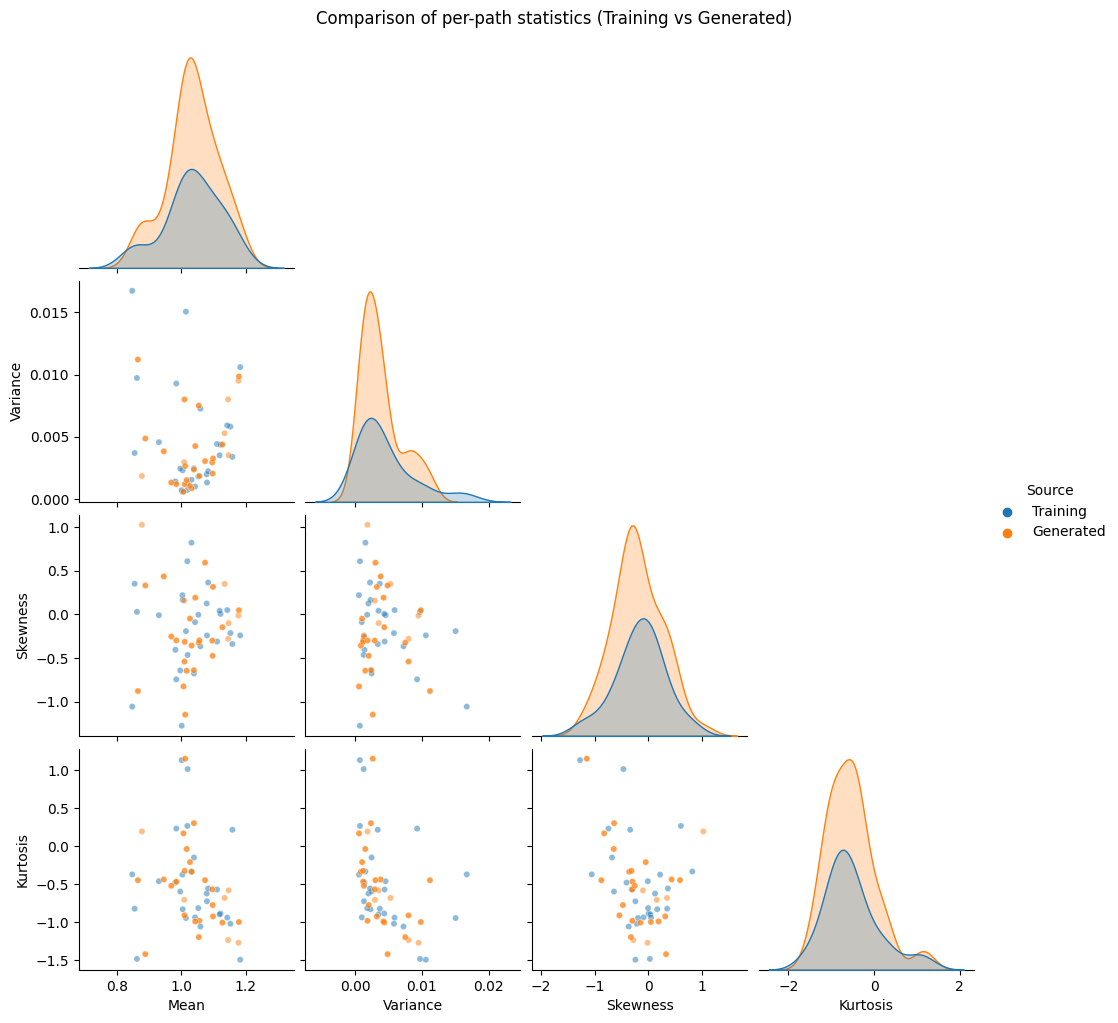

KS test on     Mean: statistic=0.137, p-value=0.835
KS test on Variance: statistic=0.100, p-value=0.983
KS test on Skewness: statistic=0.223, p-value=0.282
KS test on Kurtosis: statistic=0.137, p-value=0.835
Linear kernel MMD^2: 0.0021
RBF kernel MMD^2 = -2.1170e-02,  sigma = 0.547


In [79]:
mmd_sq_hybrid, mmd_val_hybrid, sigma_hybrid,p_val_hybrid=moment_check(true_paths_multi, all_hybrid_paths_multi)

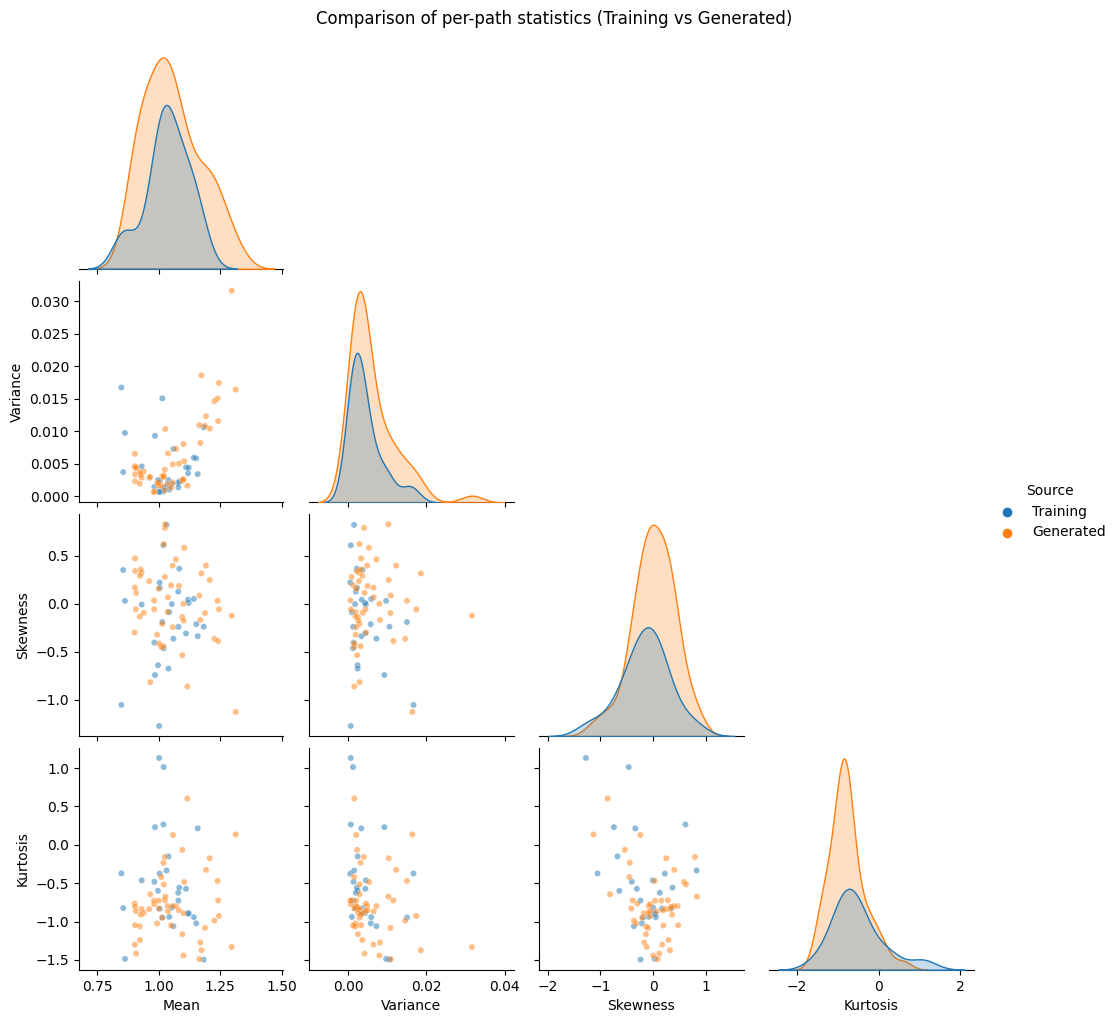

KS test on     Mean: statistic=0.204, p-value=0.381
KS test on Variance: statistic=0.220, p-value=0.297
KS test on Skewness: statistic=0.240, p-value=0.210
KS test on Kurtosis: statistic=0.296, p-value=0.068
Linear kernel MMD^2: 0.0941
RBF kernel MMD^2 = 1.9601e-03,  sigma = 0.484


In [78]:
mmd_sq_kkr, mmd_val_krr, sigma_krr,p_val_krr=moment_check(true_paths_multi, all_krr_paths_multi)

# Summary stats

In [81]:
index = ['bootstrap','hybrid','KRR']
sig_mmd_sq = [mmd_bootstrap,mmd_hybrid,mmd_krr]
mmd_sq_kkr, mmd_val_krr, sigma_krr,p_val_krr
moment_linear_mmd_sq = [mmd_sq_bootstrap,mmd_sq_hybrid,mmd_sq_kkr]
rbf_mmd_sq = [mmd_val_bootstrap,mmd_val_hybrid,mmd_val_krr]
sigma = [sigma_bootstrap,sigma_hybrid,sigma_krr]
mean_ks = [p_val_bootstrap[0],p_val_hybrid[0],p_val_krr[0]]
var_ks = [p_val_bootstrap[1],p_val_hybrid[1],p_val_krr[1]]
skew_ks = [p_val_bootstrap[2],p_val_hybrid[2],p_val_krr[2]]
kur_ks = [p_val_bootstrap[3],p_val_hybrid[3],p_val_krr[3]]

df_metrics = pd.DataFrame({
    'sig_MMD^2': sig_mmd_sq,
    'linear_MMD^2': moment_linear_mmd_sq,
    'RBF_MMD^2': rbf_mmd_sq,
    'sigma': sigma,
    'KS_pval_mean': mean_ks,
    'KS_pval_var': var_ks,
    'KS_pval_skew': skew_ks,
    'KS_pval_kurt': kur_ks
}, index=index)

pd.set_option('display.float_format', lambda x: f'{x:,.4e}')
df_metrics

,sig_MMD^2,linear_MMD^2,RBF_MMD^2,sigma,KS_pval_mean,KS_pval_var,KS_pval_skew,KS_pval_kurt
bootstrap,7.9414e-03,3.4308e-02,2.0730e-02,6.1530e-01,1.3558e-01,2.6918e-01,9.5834e-01,3.2042e-03
hybrid,1.0370e-03,2.1179e-03,-2.1170e-02,5.4653e-01,8.3495e-01,9.8285e-01,2.8189e-01,8.3495e-01
KRR,4.7504e-03,9.4136e-02,1.9601e-03,4.8450e-01,3.8140e-01,2.9686e-01,2.0981e-01,6.7546e-02


# Evaluation
## MMD

In [25]:
def get_path_signatures(ts, paths, window_size, sig_level, logsig):
    """
    Calculates signatures for all sliding windows of a collection of paths.
    """
    all_signatures = []
    for path in paths:
        current_ts = ts[:len(path)]
        path_2d = np.stack([current_ts, path], axis=1)
        for i in range(len(path) - window_size + 1):
            window = path_2d[i : i + window_size]
            if logsig == False:
                sig = iisignature.sig(window, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window, s)
            all_signatures.append(sig)
    return np.array(all_signatures)

def mmd_signature_linear(ts, paths1, paths2, window_size, sig_level):
    """
    Calculates the MMD between two collections of paths using the linear signature kernel.
    This is the squared Euclidean distance between the mean signatures.
    """
    sigs1 = get_path_signatures(ts, paths1, window_size, sig_level, False)
    sigs2 = get_path_signatures(ts, paths2, window_size, sig_level, False)

    if sigs1.shape[0] == 0 or sigs2.shape[0] == 0:
        return 0.0

    mean_sig1 = np.mean(sigs1, axis=0)
    mean_sig2 = np.mean(sigs2, axis=0)

    mmd_sq = np.sum((mean_sig1 - mean_sig2)**2)
    return mmd_sq

In [26]:
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_multi, true_paths_multi, all_bootstrap_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.007941


## Moment check 

In [39]:
def path_stats(paths,logrtn=False):
    """Compute per-path mean, variance, skew, and kurtosis of log-returns."""
    stats = []
    for p in paths:
        if logrtn:
            r = np.diff(np.log(p))  # log-returns
        else:
            r = p
        stats.append([
            np.mean(r),
            np.var(r, ddof=1),
            skew(r, bias=False),
            kurtosis(r, fisher=True, bias=False)  # excess kurtosis
        ])
    return np.array(stats)

train_stats = path_stats(true_paths_multi)
gen_stats   = path_stats(all_bootstrap_paths_multi)

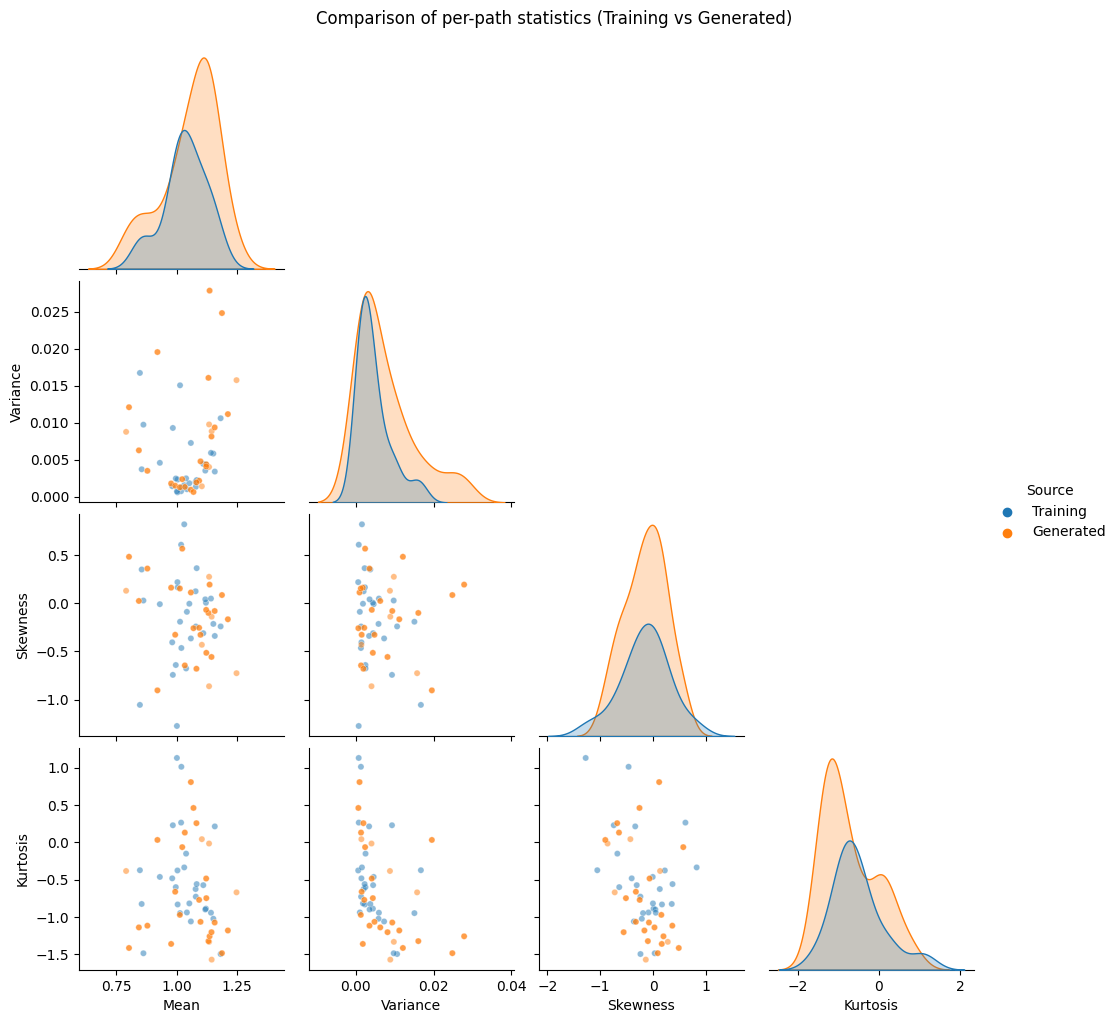

In [40]:
labels = ["Mean", "Variance", "Skewness", "Kurtosis"]

df_train = pd.DataFrame(train_stats, columns=labels)
df_train["Source"] = "Training"

df_gen = pd.DataFrame(gen_stats, columns=labels)
df_gen["Source"] = "Generated"

df_all = pd.concat([df_train, df_gen], ignore_index=True)
df_all = df_all.replace([np.inf, -np.inf], np.nan).dropna()

sns.pairplot(df_all, hue="Source", diag_kind="kde", corner=True,
             plot_kws=dict(alpha=0.5, s=20))
plt.suptitle("Comparison of per-path statistics (Training vs Generated)", y=1.02)
plt.show()

we see that skew is bit too tight comparing to training data; variance is too big.

## KS test

In [52]:
labels = ["mean", "variance", "skew", "kurtosis"]
for i, name in enumerate(labels):
    stat, pval = ks_2samp(train_stats[:, i], gen_stats[:, i])
    print(f"KS test on {name:>8}: statistic={stat:.3f}, p-value={pval:.3f}")

KS test on     mean: statistic=0.263, p-value=0.136
KS test on variance: statistic=0.226, p-value=0.269
KS test on     skew: statistic=0.110, p-value=0.958
KS test on kurtosis: statistic=0.409, p-value=0.003


KS test kurtosis reject the null hypothesis meaning the kurtosis distribution is not quite the same.

## MMD

In [57]:
mean_train = np.mean(train_stats, axis=0)
mean_gen = np.mean(gen_stats, axis=0)

mmd_sq = np.sum((mean_train - mean_gen)**2)
mmd_sq

0.03430768633716852

In [58]:
def compute_mmd(X, Y, kernel='rbf', sigma=None):
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    
    # pairwise squared distances
    XX = cdist(X, X, 'sqeuclidean')
    YY = cdist(Y, Y, 'sqeuclidean')
    XY = cdist(X, Y, 'sqeuclidean')
    
    # bandwidth heuristic
    if sigma is None:
        pairwise_dists = np.concatenate([XX.flatten(), YY.flatten(), XY.flatten()])
        sigma = np.sqrt(0.5 * np.median(pairwise_dists[pairwise_dists > 0]))
    
    # kernel matrices
    Kxx = np.exp(-XX / (2 * sigma**2))
    Kyy = np.exp(-YY / (2 * sigma**2))
    Kxy = np.exp(-XY / (2 * sigma**2))
    
    n, m = len(X), len(Y)
    mmd2 = (
        (Kxx.sum() - np.trace(Kxx)) / (n * (n - 1))
        + (Kyy.sum() - np.trace(Kyy)) / (m * (m - 1))
        - 2 * Kxy.mean()
    )
    return mmd2, sigma

mmd_val, sigma_used = compute_mmd(train_stats, gen_stats)
print(f"MMD^2 = {mmd_val:.4e},  sigma = {sigma_used:.3f}")
print(f"MMD = {np.sqrt(mmd_val):.4e}")

MMD^2 = 2.0730e-02,  sigma = 0.615
MMD = 1.4398e-01


In [76]:
def moment_check(path1,path2):
    stats1 = path_stats(path1)
    stats2   = path_stats(path2)
    
    labels = ["Mean", "Variance", "Skewness", "Kurtosis"]
    df_train = pd.DataFrame(stats1, columns=labels)
    df_train["Source"] = "Training"
    df_gen = pd.DataFrame(stats2, columns=labels)
    df_gen["Source"] = "Generated"
    df_all = pd.concat([df_train, df_gen], ignore_index=True)
    df_all = df_all.replace([np.inf, -np.inf], np.nan).dropna()
    sns.pairplot(df_all, hue="Source", diag_kind="kde", corner=True,
                 plot_kws=dict(alpha=0.5, s=20))
    plt.suptitle("Comparison of per-path statistics (Training vs Generated)", y=1.02)
    plt.show()
    p_val = []
    for i, name in enumerate(labels):
        stat, pval = ks_2samp(stats1[:, i], stats2[:, i])
        print(f"KS test on {name:>8}: statistic={stat:.3f}, p-value={pval:.3f}")
        p_val.append(pval)
    mean_train = np.mean(stats1, axis=0)
    mean_gen = np.mean(stats2, axis=0)

    mmd_sq = np.sum((mean_train - mean_gen)**2)
    print(f'Linear kernel MMD^2: {mmd_sq:.4f}')
    mmd_val, sigma_used = compute_mmd(stats1, stats2)
    print(f"RBF kernel MMD^2 = {mmd_val:.4e},  sigma = {sigma_used:.3f}")
    return mmd_sq, mmd_val, sigma_used,p_val

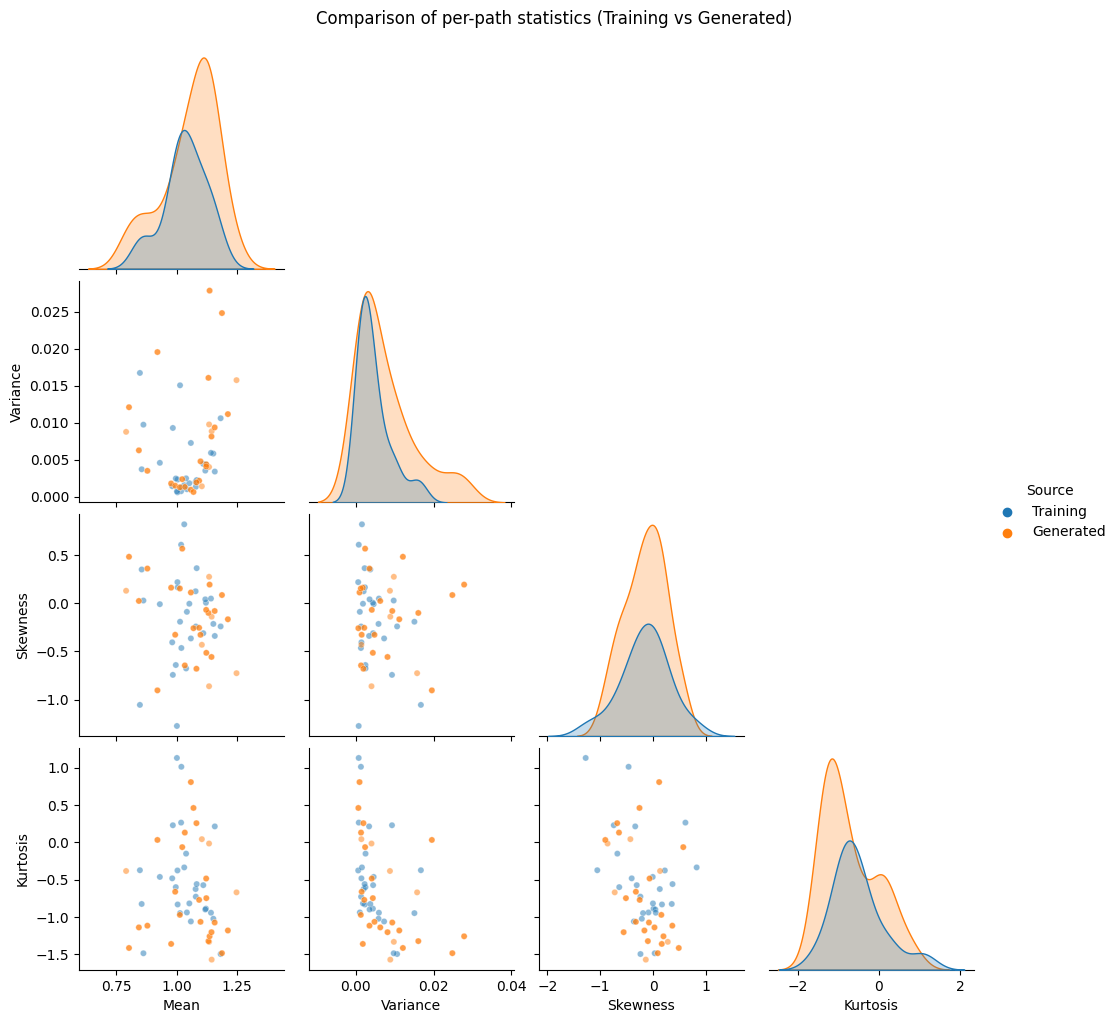

KS test on     Mean: statistic=0.263, p-value=0.136
KS test on Variance: statistic=0.226, p-value=0.269
KS test on Skewness: statistic=0.110, p-value=0.958
KS test on Kurtosis: statistic=0.409, p-value=0.003
Linear kernel MMD^2: 0.0343
RBF kernel MMD^2 = 2.0730e-02,  sigma = 0.615


(0.03430768633716852,
 0.020730059111952026,
 0.6153020986194796,
 [0.13557831219596897,
  0.26917518815254005,
  0.958340909250652,
  0.003204197087518884])

In [77]:
moment_check(true_paths_multi, all_bootstrap_paths_multi)